In [3]:
import sys
sys.executable

'/Users/virenbajaj/anaconda3/envs/TEST/bin/python'

In [2]:
import overpy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import json
import requests
import geopy
import geopandas as gpd
api = overpy.Overpass()
dir(api)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_regex_extract_error_msg',
 '_regex_remove_tag',
 'default_read_chunk_size',
 'default_url',
 'parse_json',
 'parse_xml',
 'query',
 'read_chunk_size',
 'url',
 'xml_parser']

In [2]:
api.url

'http://overpass-api.de/api/interpreter'

## Objectives 
1. Get Points of Interest from open data sources like open street map (OSM).  
        whats a POI in OSM: https://wiki.openstreetmap.org/wiki/Points_of_interest
        What POIs make up a commercial center?
        Query for these POIs
        
2. Understand how spatial location data works
        https://www.esri.com/library/whitepapers/pdfs/shapefile.pdf
        
3. Understand spatial vector data types and how to manipulate it using your language of choice.  
4. Understand necessary GIS concepts like projections, spatial clustering, etc.  
5. Figure out a way of clustering these points into commercial centres/markets.  
6. Visualize the regions of interest  




## POI's that represent a commercial center?
Restaurants  
Bar  
Pub
Cafes
ATM/BANK  

Corporate Commercial Offices


Trees 
traffic lights
night time lighting




In [6]:
from geopy.geocoders import Nominatim
import overpy

city_name = "pittsburgh"

# Geocoding request via Nominatim
geolocator = Nominatim(user_agent="city_compare")
geo_results = geolocator.geocode(city_name, exactly_one=False, limit=3)

# Searching for relation in result set
for r in geo_results:
    print(r.address, r.raw.get("osm_type"))
    if r.raw.get("osm_type") == "relation":
        city = r
        break

PGH, Allegheny County, Pennsylvania, USA relation


In [78]:
# Calculating area id
area_id = int(city.raw.get("osm_id")) + 3600000000

# Excecuting overpass call
api = overpy.Overpass()
overpass_query = f"""
    [out:xml][timeout:180];
    area({area_id})->.searchArea;
    (
      node["amenity"="restaurant"](area.searchArea);
      way["amenity"="restaurant"](area.searchArea);
      relation["amenity"="restaurant"](area.searchArea);
      node["amenity"="pub"](area.searchArea);
      way["amenity"="pub"](area.searchArea);
      relation["amenity"="pub"](area.searchArea);
      node["amenity"="bar"](area.searchArea);
      way["amenity"="bar"](area.searchArea);
      relation["amenity"="bar"](area.searchArea);
    );
    out center;
    """

In [38]:
result = api.query(overpass_query)

In [126]:
print(area_id)

3600188553


In [79]:
response = requests.get(api.url, 
                        params={'data': overpass_query})


In [80]:
type(response.content)

bytes

In [81]:
with open('restpubbar.osm', 'wb') as f:
    f.write(response.content)

In [60]:
from xml.etree import ElementTree

In [61]:
# tree = ElementTree.fromstring(response.content)

In [82]:
!./node_modules/osmtogeojson/osmtogeojson restpubbar.osm > pgh.geojson

{'version': '0.6', 'generator': 'Overpass API 0.7.55.5 2ca3f387'}

In [78]:
# import urllib, geojson, gdal, subprocess
# url= ' http://ig3is.grid.unep.ch/istsos/wa/istsos/services/ghg/procedures/operations/geojson?epsg=4326'
# response = urllib.urlopen(url)
# data = geojson.loads(response.read())

# with open('data.geojson', 'w') as f:
#     geojson.dump(data, f)

# args = ['ogr2ogr', '-f', 'ESRI Shapefile', 'destination_data.shp', 'data.geojson']
# subprocess.Popen(args)


In [83]:
gdf = gpd.read_file('pgh.geojson')

In [84]:
gdf.head()

,addr:city,addr:housenumber,addr:postcode,addr:street,amenity,building,building:levels,cuisine,name,phone,...,craft,organic,atm,atm:operator,brunch,opening_hours:atm,branch,fireplace,sport,geometry
0,Pittsburgh,420,15213,South Craig Street,restaurant,yes,3,american,The Bagel Factory,(412) 681-1101,...,None,None,None,None,None,None,None,None,None,POINT (-79.9488892 40.4445889)
1,Pittsburgh,302,15206,South Saint Clair Street,pub,yes,None,None,Sharp Edge Beer Emporium,None,...,None,None,None,None,None,None,None,None,None,POINT (-79.93083590000001 40.4599906)
2,Pittsburgh,5430,15232,Centre Avenue,restaurant,yes,None,None,Panera Bread,None,...,None,None,None,None,None,None,None,None,None,POINT (-79.9374332 40.4560504)
3,Pittsburgh,242,15219,West Station Square Drive,restaurant,commercial,None,american,The Melting Pot,+1 412 261 3477,...,None,None,None,None,None,None,None,None,None,POINT (-80.0053125 40.434352)
4,None,None,None,None,restaurant,yes,None,None,Hard Rock Cafe,None,...,None,None,None,None,None,None,None,None,None,POINT (-80.0049128 40.4339776)


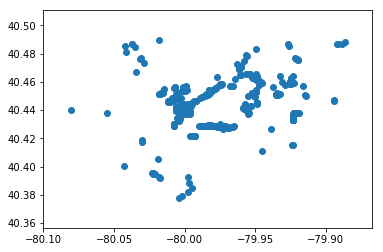

In [85]:
gdf.plot()

In [86]:
gdf.crs

{'init': 'epsg:4326'}

In [87]:
gdf['geoid'] = gdf.index.astype(str)
jsontxt = gdf.to_json()

In [88]:
lats =  gdf["geometry"][:].x
lons = gdf["geometry"][:].y
print(len(lats),len(lons), np.mean(lats), np.mean(lons))

458 458 -79.97458885393011 40.444927484934496


In [89]:
import folium
from folium.plugins import FastMarkerCluster
import os

In [91]:
# %%time

callback = """\
function (row) {
    var icon, marker;
    icon = L.AwesomeMarkers.icon({
        icon: "map-marker", markerColor: "red"});
    marker = L.marker(new L.LatLng(row[0], row[1]));
    marker.setIcon(icon);
    return marker;
};
"""

# Create a Map instance
m1 = folium.Map(location=[40.4406, -79.9959],
                   zoom_start=12, control_scale=True)

# m1 = folium.Map(
#     location=[np.mean(lats), np.mean(lons)],
#     tiles='Cartodb Positron',
#     zoom_start=1
# )
print(m1)
FastMarkerCluster(
    data=list(zip(lons, lats)),
    callback=callback
).add_to(m1)


m1.save('pgh_rest_marker_clusters.html')
m1

NameError: name 'm1' is not defined

In [16]:
outfp = "base_map.html"

In [17]:
m.save(outfp)

In [18]:
# Let's change the basemap style to 'Stamen Toner'
m = folium.Map(location=[40.730610, -73.935242], tiles='Stamen Toner',
                zoom_start=12, control_scale=True, prefer_canvas=True)

 # Filepath to the output
outfp = "base_map2.html"

# Save the map
m.save(outfp)

In [6]:
neighborhoods= gpd.read_file('geojson/Neighborhoods_.geojson')

NameError: name 'gdf' is not defined

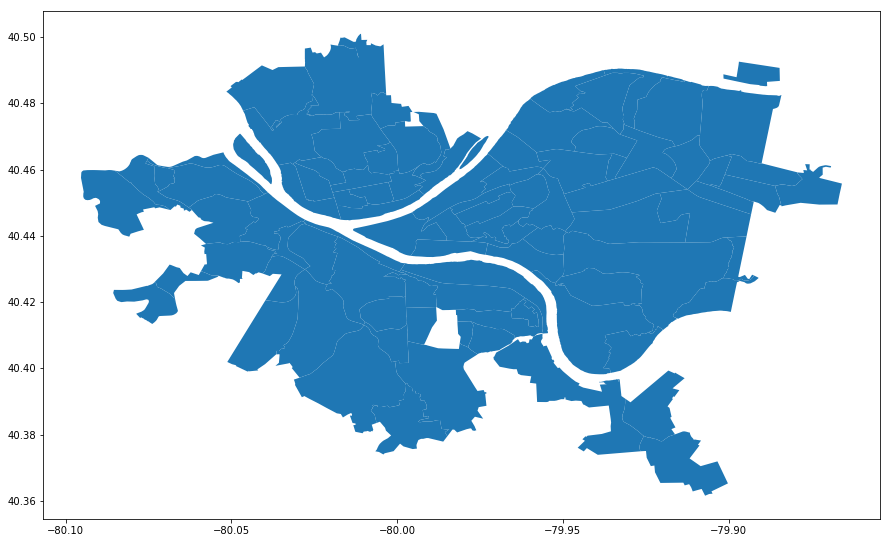

In [7]:
p = neighborhoods.plot(figsize=(15,15))
# gdf.plot(ax=p,color='red',markersize=2)

In [8]:
neighborhoods.to_crs('+proj=utm +zone=17T +ellps=WGS84 +datum=WGS84 +units=m +no_defs',inplace=True)

In [17]:
print(neighborhoods.crs)
(neighborhoods.columns)

+proj=utm +zone=17T +ellps=WGS84 +datum=WGS84 +units=m +no_defs


Index(['objectid', 'fid_blockg', 'statefp10', 'countyfp10', 'tractce10',
       'blkgrpce10', 'geoid10', 'namelsad10', 'mtfcc10', 'funcstat10',
       'aland10', 'awater10', 'intptlat10', 'intptlon10', 'shape_leng',
       'fid_neighb', 'area', 'perimeter', 'neighbor_', 'neighbor_i', 'hood',
       'hood_no', 'acres', 'sqmiles', 'dpwdiv', 'unique_id', 'sectors',
       'shape_le_1', 'shape_ar_1', 'page_number', 'plannerassign',
       'created_user', 'created_date', 'last_edited_user', 'last_edited_date',
       'Shape__Area', 'Shape__Length', 'geometry'],
      dtype='object')

In [21]:
neighborhoods.unique_id = neighborhoods.unique_id.map(str)

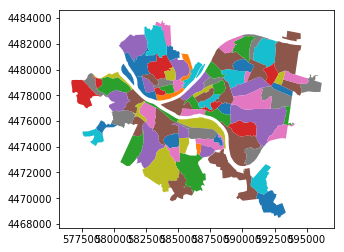

In [26]:
(neighborhoods.plot(column='unique_id'))

In [25]:

zoning = gpd.read_file('Zoning.geojson')
zoning

,objectid,area,perimeter,zoning_,zoning_id,zon_new,shape_leng,correctionlabel,full_zoning_type,legendtype,municode,status,created_user,created_date,last_edited_user,last_edited_date,Shape__Area,Shape__Length,geometry
0,1003,3.131566e+05,3950.254535,505.0,505.0,RP,3950.254535,None,RESIDENTIAL PLANNED UNIT DEVELOPMENT,Planned Unit Development,http://library.municode.com/HTML/13525/level4/...,Approved,pgh.admin,2019-03-12T14:47:45,pgh.admin,2019-03-12T14:47:45,3.131566e+05,3950.254535,"POLYGON ((-79.980312373364 40.4449352810457, -..."
1,1004,6.630129e+06,27722.333689,507.0,507.0,R2-L,27722.333689,None,TWO-UNIT RESIDENTIAL LOW DENSITY,Two-Unit Residential,http://library.municode.com/HTML/13525/level4/...,Approved,pgh.admin,2019-03-12T14:47:45,pgh.admin,2019-03-12T14:47:45,6.630129e+06,27722.333689,"POLYGON ((-79.9190855776725 40.4460779245012, ..."
2,1005,2.907277e+06,14342.341951,627.0,627.0,UNC,14342.341951,None,URBAN NEIGHBORHOOD COMMERCIAL,Urban Neighborhood Commercial,http://library.municode.com/HTML/13525/level4/...,Approved,pgh.admin,2019-03-12T14:47:45,pgh.admin,2019-03-12T14:47:45,2.907277e+06,14342.341951,"POLYGON ((-80.00120091447521 40.4503526560754,..."
3,1006,1.497438e+07,51430.489766,640.0,640.0,R2-L,51430.489766,None,TWO-UNIT RESIDENTIAL LOW DENSITY,Two-Unit Residential,http://library.municode.com/HTML/13525/level4/...,Approved,pgh.admin,2019-03-12T14:47:45,pgh.admin,2019-03-12T14:47:45,1.497570e+07,51227.951024,"POLYGON ((-80.0720824290329 40.4533268164503, ..."
4,1007,9.769159e+05,7215.883942,660.0,660.0,UNC,8527.517294,None,URBAN NEIGHBORHOOD COMMERCIAL,Urban Neighborhood Commercial,http://library.municode.com/HTML/13525/level4/...,Approved,pgh.admin,2019-03-12T14:47:45,pgh.admin,2019-03-12T14:47:45,1.117801e+06,8549.556959,"POLYGON ((-79.93517087921489 40.4572977888893,..."
5,1008,2.696972e+06,11090.497849,666.0,666.0,R1D-M,11090.497849,None,SINGLE-UNIT DETACHED RESIDENTIAL MODERATE DENSITY,Single-Unit Detached Residential,http://library.municode.com/HTML/13525/level4/...,Approved,pgh.admin,2019-03-12T14:47:45,pgh.admin,2019-03-12T14:47:45,2.696972e+06,11090.497849,"POLYGON ((-80.0661138592497 40.4517771067364, ..."
6,1009,2.041785e+06,8894.747576,740.0,740.0,R1A-VH,8894.747576,None,SINGLE-UNIT ATTACHED RESIDENTIAL VERY HIGH DEN...,Single-Unit Attached Residential,http://library.municode.com/HTML/13525/level4/...,Approved,pgh.admin,2019-03-12T14:47:45,pgh.admin,2019-03-12T14:47:45,2.041785e+06,8894.747576,"POLYGON ((-80.0263308445667 40.4592511678789, ..."
7,1010,7.068856e+06,14911.301268,806.0,806.0,R1D-L,14911.301268,None,SINGLE-UNIT DETACHED RESIDENTIAL LOW DENSITY,Single-Unit Detached Residential,http://library.municode.com/HTML/13525/level4/...,Approved,pgh.admin,2019-03-12T14:47:45,pgh.admin,2019-03-12T14:47:45,7.068856e+06,14911.301268,"POLYGON ((-80.07584331417689 40.4618387292767,..."
8,1011,3.845341e+06,12979.717756,878.0,878.0,R1D-H,12979.717756,None,SINGLE-UNIT DETACHED RESIDENTIAL HIGH DENSITY,Single-Unit Detached Residential,http://library.municode.com/HTML/13525/level4/...,Approved,pgh.admin,2019-03-12T14:47:45,pgh.admin,2019-03-12T14:47:45,3.845341e+06,12979.717756,"POLYGON ((-79.93363899266269 40.4702012274187,..."
9,1012,4.007773e+06,21458.398665,914.0,914.0,R1D-H,21458.398665,None,SINGLE-UNIT DETACHED RESIDENTIAL HIGH DENSITY,Single-Unit Detached Residential,http://library.municode.com/HTML/13525/level4/...,Approved,pgh.admin,2019-03-12T14:47:45,pgh.admin,2019-03-12T14:47:45,4.007773e+06,21458.398664,"POLYGON ((-80.0058925453025 40.4658838862334, ..."


In [ ]:
zoning['full_zoning_type']==

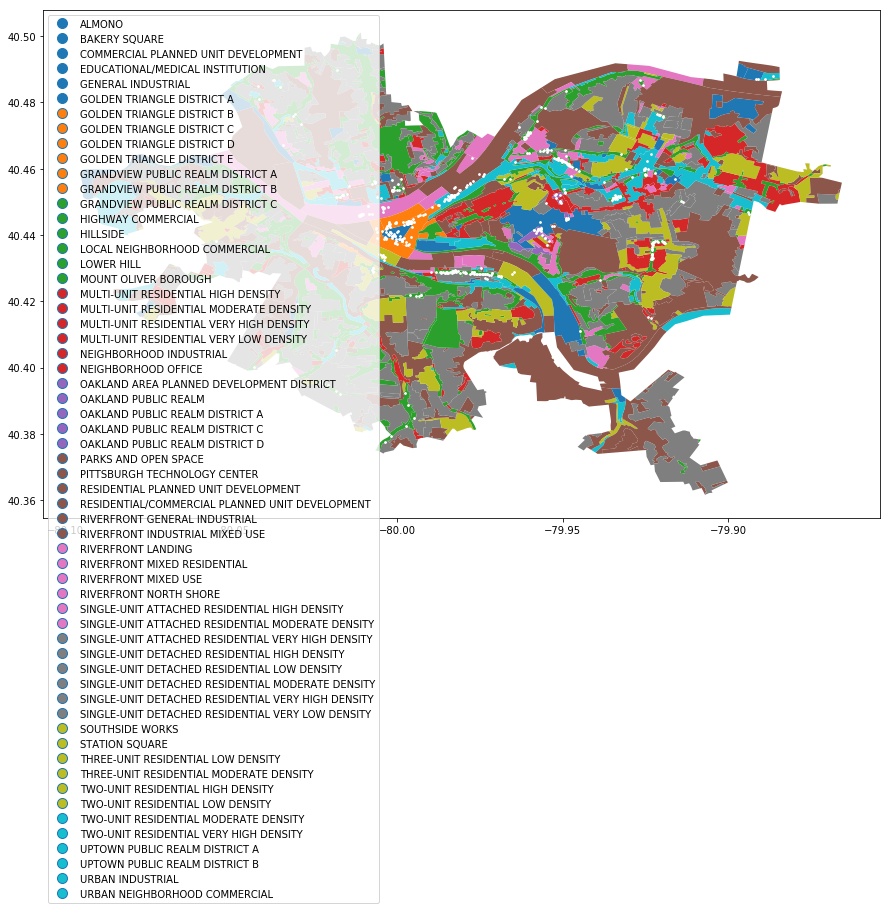

In [125]:
z = zoning.plot(column='full_zoning_type',figsize=(15,15),legend=True)
gdf.plot(ax=z,color='white',markersize=3)

In [120]:
dir(z)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_cachedRenderer',
 '_clipon',
 '_clippath',
 '_connected',
 '_contains',
 '_current_image',
 '_facecolor',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_hold',
 '_in_layout',
 '_init_axis',
 '_label',
 '_layoutbox',
 '_left_title',
 '_make_twin_axes',
 '_mouseover',
 '_m

In [56]:
pos_arr = np.asarray([[float(node.lat),float(node.lon)] for node in result.nodes])

In [61]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(pos_arr)

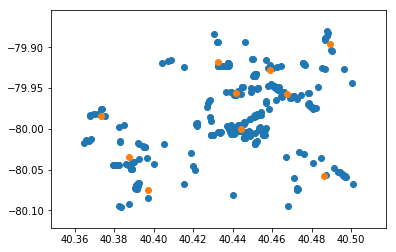

In [68]:
# f = plt.figure(figsize=(12,5))
# plt.xlim(-80.0955170,-79.8657280)
# plt.ylim(40.3615200,40.5012021)
plt.scatter(pos_arr[:,0],pos_arr[:,1])
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1])
# plt.axis('equal')